In [82]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import random
import matplotlib.pyplot as plt

In [83]:
cd ..

/Users/oliviawatkins/Documents


In [84]:
from neural_nets_library import training

In [85]:
class Controller(nn.Module):
    """
    Contains the two learnable parts of the model in four independent, fully connected layers.
    First the initial values for the registers and instruction registers and second the 
    parameters that computes the required distributions. 
    """

    def __init__(self, 
                 first_arg = None, 
                 second_arg = None, 
                 output = None, 
                 instruction = None, 
                 initial_registers = None, 
                 stop_threshold = .99, 
                 multiplier = 10,
                 correctness_weight = .2, 
                 halting_weight = .2, 
                 confidence_weight = .2, 
                 efficiency_weight = .4,
                 t_max = 100):
        #TODO: Read over ANC paper, check if there are more reasonable default initial values.
        """
        Initialize a bunch of constants and pass in matrices defining a program.
        
        :param first_arg: Matrix with the 1st register argument for each timestep stored in the columns (1xRxM)
        :param second_arg: Matrix with the 2nd register argument for each timestep stored in the columns (1xRxM)
        :param output: Matrix with the output register for each timestep stored in the columns (1xRxM)
        :param instruction: Matrix with the instruction for each timestep stored in the columns (1xNxM)
        :param initial_registers: Matrix where each row is a distribution over the value in one register (1xRxM)
        :param stop_threshold: The stop probability threshold at which the controller should stop running
        :param multiplier: The factor our one-hot vectors are be multiplied by before they're softmaxed to add blur
        :param correctness_weight: Weight given to the correctness component of the loss function
        :param halting_weight: Weight given to the halting component of the loss function
        :param confidence_weight: Weight given to the confidence component of the loss function
        :param efficiency_weight: Weight given to the efficiency component of the loss function
        
        """
        super(Controller, self).__init__()
        
        # Initialize dimension constants
        B, R, M = initial_registers.size()
        self.M = M
        self.R = R
        
        # Initialize loss function weights
        # In the ANC paper, these scalars are called, alpha, beta, gamma, and delta
        self.correctness_weight = correctness_weight
        self.halting_weight = halting_weight
        self.confidence_weight = confidence_weight
        self.efficiency_weight = efficiency_weight
        
        
        # And yet more initialized constants... yeah, there are a bunch, I know.
        self.t_max = t_max
        self.stop_threshold = stop_threshold
        

        # Initialize parameters.  These are the things that are going to be optimized. 
        self.first_arg = nn.Parameter(multiplier * first_arg)
        self.second_arg = nn.Parameter(multiplier * second_arg)
        self.output = nn.Parameter(multiplier * output)
        self.instruction = nn.Parameter(multiplier * instruction) 
        initial_registers = self.blur(initial_registers, multiplier, 2)
        self.registers = nn.Parameter(initial_registers.data)
        
#         print("INITIAL REGS", initial_registers)
        
        
        # Machine initialization
        self.machine = Machine(B, M, R)
    
    def blur(self, matrix, scale_factor, dimension):
        """
        Takes a matrix, each row (or column) of which is a one-hot vector.
        Multiply each 1 by a constant and then softmax it, which 
        effectively "blurs" the matrix a little bit.
        
        :param matrix: Matrix to blur
        :param scale_factor: Constant to multiply the matrix by before it's softmaxed
        :param dimension: Dimension to softmax over
        
        :return: Blurred matrix
        """
        matrix = scale_factor * matrix
        softmax = nn.Softmax(dimension)
        return softmax(Variable(matrix))    
    
    
        
    def forward(self, input, train):
        """
        Runs the controller on a certain input memory matrix.
        It either returns the loss or the output memory.
        
        :param input: A three-tuple of three MxM matrices: (memory matrix, output_memory, output_mask)
        
        :return: If train is true, return the loss. Otherwise, return the output matrix
        """
        # Program's initial memory
        self.memory = input[0]
        # Desired output memory
        self.output_memory = Variable(input[1])
        # Mask with 1's in the rows of the output memory matrix which actually contain the answer.
        self.output_mask = Variable(input[2])
    
        
        # Initialize instruction regiser (1xMx1)
        self.register_buffer('IR', torch.DoubleTensor(1, M, 1).zero_())
        self.IR[0, 0, 0] = 1
        
        IR = Variable(self.IR)
        self.memory = Variable(self.memory)
        
#         print("INITIAL MEMORY", self.memory)
        
        efficiency_loss = 0
        confidence_loss = 0
        self.stop_probability = 0
        
        # Copy registers so we aren't using the values from the previous iteration.
        registers = self.registers
        
        # loss initialization
        self.confidence = 0
        self.efficiency = 0
        self.halting = 0
        self.correctness = 0
        
        t = 0 
        # Run the program, one timestep at a time, until the program terminates or whe time out
        while t < self.t_max and self.stop_probability < self.stop_threshold: 
            
            softmax = nn.Softmax(1)
            
            a = softmax(torch.bmm(self.first_arg, IR))
            b = softmax(torch.bmm(self.second_arg, IR))
            o = softmax(torch.bmm(self.output, IR))
            e = softmax(torch.bmm(self.instruction, IR))
            
            old_mem = self.memory
            
            # Update memory, registers, and IR after machine operation
            self.old_stop_probability = self.stop_probability
            self.memory, registers, IR, new_stop_prob = self.machine(e, a, b, o, self.memory, registers, IR) 
            
            self.stop_probability += new_stop_prob[0]
            
            # If we're training, calculate loss
            if train:
                self.timestep_loss(t)
            
            t += 1
        
        # If we're training, return loss.  Otherwise return memory.
        if train:
            self.final_loss(t)
            total_loss  = self.total_loss()
            return (self.memory, total_loss)
        else:
            return (self.memory, None)
        
        
    def timestep_loss(self, t):
        """
        @ Rakia @ Aditya feel free to use this function definition or not.  My main thought was that this would 
        compute the types of loss which get updated every timestep.
        """
        # Confidence Loss 
        mem_diff = self.output_memory - self.memory
        correctness = torch.sum((self.output_mask) * mem_diff * mem_diff)
        self.confidence += (self.stop_probability - self.old_stop_probability) * correctness
        
        # Efficiency Loss
        if t < self.t_max and self.stop_probability < self.stop_threshold: # don't add efficiency loss on the last timestep
            self.efficiency += (1 - self.stop_probability)
            
    
    def final_loss(self, t):
        """
        @ Rakia @ Aditya feel free to use this function definition or not.  My main thought was that this would 
        compute the types of loss which get updated every timestep.
        """
        # Correctness loss
        mem_diff = self.output_memory - self.memory
        self.correctness = torch.sum((self.output_mask) * mem_diff * mem_diff)

        # Halting loss
        if t == self.t_max:
            self.halting = (1 - self.stop_probability)

    def total_loss(self):
        """ compute four diferent loss functions and return a weighted average of the four measuring correctness, 
        halting, efficiency, and confidence"""
        return  (self.correctness*self.correctness_weight) + (self.confidence_weight*self.confidence) + (self.halting_weight*self.halting) + (self.efficiency_weight*self.efficiency) 
        
      
        
        

In [86]:
class Operation(nn.Module):
    """
    Parent class for our binary operations
    """
    def __init__(self, M):
        """
        Initialize the memory length (needed so we can mod our answer in case it exceeds the range 0-M-1)
        Also calculate the output matrix for the operation
        
        :param M: Memory length
        """
        super(Operation, self).__init__()
        self.M = M
        
        # Create a MxMxM matrix where the (i,j,k) cell is 1 iff operation(i,j) = k.
        self.outputs = torch.IntTensor(M, M, M).zero_()
        for i in range(M):
            for j in range(M):
                val = self.compute(i, j)
                self.outputs[val][i][j] = 1
                
        self.outputs = Variable(self.outputs)
    
    def compute(self, x, y):
        """ 
        Perform the binary operation.  The arguments may or may not be used.
        
        :param x: First argument
        :param y: Second argument
        """
        raise NotImplementedError
    
    def forward(self):
        """
        :return: The output matrix
        """
        return self.outputs

In [87]:
class Add(Operation):

    def __init__(self, M):
        super(Add, self).__init__(M)
    
    def compute(self, x, y):
        return (x + y) % self.M


In [88]:
class Stop(Operation):
    
    def __init__(self, M):
        super(Stop, self).__init__(M)

    def compute(self, _1, _2):
        return 0

In [89]:
class Jump(Operation):
    
    def __init__(self, M):
        super(Jump, self).__init__(M)

    def compute(self, _1, _2):
        return 0 # Actual jump happens in the Machine class

In [90]:
class Decrement(Operation):
    
    def __init__(self, M):
        super(Decrement, self).__init__(M)

    def compute(self, x, _):
        return (x - 1) % self.M

In [91]:
class Increment(Operation):
    
    def __init__(self, M):
        super(Increment, self).__init__(M)

    def compute(self, x, _):
        return (x + 1) % self.M

In [92]:
class Max(Operation):
    
    def __init__(self, M):
        super(Max, self).__init__(M)

    def compute(self, x, y):
        return max(x,y)

In [93]:
class Min(Operation):
    
    def __init__(self, M):
        super(Min, self).__init__(M)

    def compute(self, x, y):
        return min(x,y)

In [94]:
class Read(Operation):
    
    def __init__(self, M):
        super(Read, self).__init__(M)
        # Leave output matrix blank since we're gonna do the reading elsewhere
        self.outputs = torch.DoubleTensor(M, M, M).zero_()

    def compute(self, x, _):
        return 0 # Actual reading happens in the Machine class

In [95]:
class Subtract(Operation):
    
    def __init__(self, M):
        super(Subtract, self).__init__(M)

    def compute(self, x, y):
        return (x - y) % self.M

In [96]:
class Write(Operation):
    
    def __init__(self, M):
        super(Write, self).__init__(M)

    def compute(self, x, y):
        return 0 # Actual write happens in the Machine class

In [97]:
class Zero(Operation):
    
    def __init__(self, M):
        super(Zero, self).__init__(M)

    def compute(self, _1, _2):
        return 0

In [98]:
class Machine(nn.Module):
    """
    The Machine executes assembly instructions passed to it by the Controller.
    It updates the given memory, registers, and instruction pointer.
    The Machine doesn't have any learnable parameters.
    """
    def __init__(self, B, M, R):
        """
        Initializes dimensions, operations, and counters
        
        :param B: Batch size (meant to be 1)
        :param M: Memory length.  Integer values also take on values 0-M-1.  M is also the program length.
        :param R: Number of registers
        """
        super(Machine, self).__init__()
        
        # Store parameters as class variables
        self.R = R # Number of registers
        self.M = M # Memory length (also largest number)
        self.B = B # Batch size
        
        # Start off with 0 probability of stopping
        self.stop_probability = 0 
        
        # List of ops (must be in same order as the original ANC paper so compilation works right)
        self.ops = [ 
            Stop(M),
            Zero(M),
            Increment(M),
            Add(M),
            Subtract(M),
            Decrement(M),
            Min(M),
            Max(M),
            Read(M),
            Write(M),
            Jump(M)
        ]
        
        # Number of instructions
        self.N = len(self.ops)
        
        # Create a 4D matrix composed of the output matrices of each of the ops
        self.outputs = Variable(torch.DoubleTensor(self.N, M, M, M)).zero_()
        
        for i in range(self.N):
            op = self.ops[i]
            self.outputs[i] = op()
            
        # Add an extra batch dimension
        self.outputs = torch.unsqueeze(self.outputs, 0)
        self.outputs = self.outputs.expand(B, -1, -1, -1, -1)
        
        # Keep track of ops which will be handled specially
        self.jump_index = 10
        self.stop_index = 0
        self.write_index = 9
        self.read_index = 8
        

        
    def forward(self, e, a, b, o, memory, registers, IR):
        
        """
        Run the Machine for one timestep (corresponding to the execution of one line of Assembly).
        The first four parameter names correspond to the vector names used in the original ANC paper
        
        :param e: Probability distribution over the instruction being executed (BxMx1)
        :param a: Probability distribution over the first argument register (length BxRx1)
        :param b: Probability distribution over the second argument register (length BxRx1)
        :param o: Probability distribution over the first argument register (length BxRx1)
        :param memory: Memory matrix (size BxMxM)
        :param registers: Register matrix (size BxRxM)
        :param IR: Instruction Register (length BxM)
        
        :return: The memory, registers, and instruction register after the timestep
        """
        
        # Dimensions B x 1 x R -> B x 1 x R
        a = torch.transpose(a, 1, 2)
        b = torch.transpose(b, 1, 2)
        
        # Calculate distributions over the two argument values by multiplying each 
        # register by the probability that register is being used.
        arg1 = torch.bmm(a, registers)
        arg2 = torch.bmm(b, registers)
        
#         print("A", a)
#         print("REG", registers)
        
        # Multiply the output matrix by the arg1 and arg2 vectors to take into account
        # Before we do this, we're going to have to do a bunch of dimension squishing.
        
        # arg1_long dimensions: B x 1 x M --> B x 1 x 1 x 1 x M
        arg1_long = torch.unsqueeze(arg1, 1)
        arg1_long = torch.unsqueeze(arg1_long, 1)
        
        outputs_x_arg1 = torch.matmul(arg1_long, self.outputs)
        
        # outputs_x_arg1 dimensions: B x N x M x 1 x M -> B x N x M x M
        outputs_x_arg1 = torch.squeeze(outputs_x_arg1, 3)
        
        # arg2_long dimensions: B x 1 x M --> B x 1 x M x 1
        arg2_long = torch.unsqueeze(arg2, 3)
        
        outputs_x_args = torch.matmul(outputs_x_arg1, arg2_long)
        
        # outputs_x_args dimensions: B x N x M x 1 -> B x N x M
        outputs_x_args = torch.squeeze(outputs_x_args, 3)
        
        # e dimensions B x N x 1 -> B x 1 x N
        e = torch.transpose(e, 1, 2)
        
        # read_vec dimensions B x 1 -> B x 1 x 1
        read_vec =  e[:, :, self.read_index]
        read_vec = read_vec.unsqueeze(1)
        
        # Length Bx1xM vector over the output of the operation
        out_vec = torch.matmul(e, outputs_x_args)
        
        # Deal with memory reads separately
        out_vec = out_vec + read_vec * torch.matmul(arg1, memory)        
        
        # Update our memory, registers, instruction register, and stopping probability
        mem_old = memory
        memory = self.writeMemory(e, o, memory, arg1, arg2)
        registers = self.writeRegisters(out_vec, o, registers)
        IR = self.updateIR(e, IR, arg1, arg2)
        stop_prob = self.getStop(e)
        
        return(memory, registers, IR, stop_prob)
        
        
    def writeRegisters(self, out, o, registers):
        """
        Write the result of our operation to our registers.
        
        :param out: Probability distribution over the output value (Bx1xM)
        :param o: Probability distribution over the output register (BxRx1)
        :param Registers: register matrix (BxRxM)
        
        :return: The updated registers (BxRxM)
        """
        
        
        # Multiply probability of writing to each output register by the distribution over the value we're writing there.
        new_register_vals = torch.matmul(o, out)
        
        # Multiply each original register cell by the probabilty of not writing to that register
        old_register_vals = (1-o).expand(self.B, self.R, self.M) * registers
        
        # Take a weighted sum over the old and new register values
        registers =  new_register_vals + old_register_vals
     #         print("SIZE", o.size())
#         print("NEW", new_register_vals)
#         print("OLD", old_register_vals)
        
        return registers
    
    def updateIR(self, e, IR, arg1, arg2):
        """
        Update the instruction register
        
        :param e: Distribution over the current instruction (BxNx1)
        :param IR: Instruction register (length BxMx1)
        :param arg1: Distribution over the first argument value (length BxMx1)
        :param arg2: Distribution over the second argument value (length BxMx1)
        
        :return: The updated instruction register (BxMx1)
        """
        
        # Dimensions B x 1 x M -> B x M x 1
        arg2 = arg2.transpose(1, 2)
        
        # Probability that we're on the jump instruction
        jump_probability = e[:, :, self.jump_index]
        
        # Probability that the first argument is 0
        is_zero = arg1[:, :, 0]
        
        # Slicing lost a dimension.  Let's add it back
        jump_probability = torch.unsqueeze(jump_probability, 1)
        is_zero = torch.unsqueeze(is_zero, 1)
        
        # If we're not jumping, just shift IR by one slot
        wraparound = IR[:, -1]
        normal_instructions = IR[:, :-1]
        
        # For whatever reason, when you chop off one row/column, that dimension disappears.  Add it back.
        wraparound = wraparound.unsqueeze(1)
        IR_no_jump = torch.cat([wraparound, normal_instructions], 1)
        
        # If we are on a jump instruction, check whether the argument's 0.
        # If it is, jump to the location specified by arg2.  Otherwise, increment like normal.
        IR_jump = arg2 * is_zero + (1 - is_zero) * IR_no_jump
        
        # Take a weighted sum of the instruction register with and without jumping
        IR = IR_no_jump * (1 - jump_probability) + IR_jump * jump_probability
        
        return IR
    
    def writeMemory(self, e, o, mem_orig, arg1, arg2):
        """
        Update the memory
        
        :param e: Distribution over the current instruction (B x1xM)
        :param mem_orig: Current memory matrix (BxMxM)
        :param arg1: Distribution over the first argument value (Bx1xM)
        :param arg2: Distribution over the second argument value (Bx1xM)
        
        :return: The updated memory matrix (BxMxM)
        """
        
        # Probability that we're on the write instruction
        write_probability = e[:,:, self.write_index]
        
        # write_probability dimensions: Bx1 -> B x 1 x 1
        write_probability = torch.unsqueeze(write_probability, 1)
        
        # arg1 dimensions: B x 1 x M -> B x M x 1
        arg1 = torch.transpose(arg1, 1, 2)
        
        # If we are on a write instruction, write the value arg2 in register arg1. Otherwise, leave memory as is.
        mem_changed = torch.bmm(arg1, arg2)
#         print("ARG1", arg1)
#         print("ARG2", arg2)
#         print("MEM CHANGED", mem_changed)
        mem_unchanged = mem_orig * (1-arg1).expand(-1, -1, self.M)
        mem_write = mem_changed + mem_unchanged
        
        
        # Take a weighted sum over the new memory and old memory
        memory = mem_orig * (1 - write_probability) + mem_write * write_probability
        return memory
        
    def getStop(self, e):
        """
        Obtain the probability that we will stop at this timestep based on the probability that we are running the STOP op.
        
        :param e: distribution over the current instruction (length Bx1xM)
        
        :return: probability representing whether the controller should stop.
        """
        return e[:, :, self.stop_index].data[0]


In [99]:
def one_hotify(vec, length, dimension):
    """
    Turn a tensor of integers into a matrix of one-hot vectors.
    
    :param vec: The vector to be converted.
    :param length: One dimension of the matrix (the other is the length of vec)
    :param dimension: Which dimension stores the elements of vec.  If 0, they're stored in the rows.  If 1, the columns.
    
    :return A matrix of one-hot vectors, each row or column corresponding to one element of vec
    """
    x = vec.size()[0]
    if dimension == 0:
        binary_vec = torch.DoubleTensor(x, length).zero_()
        for i in range(x):
            binary_vec[i][vec[i]] = 1
        return binary_vec
    elif dimension == 1:
        binary_vec = torch.DoubleTensor(length, x).zero_()
        for i in range(x):
            binary_vec[vec[i]][i] = 1
        return binary_vec
        

In [100]:
# # Addition task
# # Generate this by running the instructions here (but with the addition program file): https://github.com/aditya-khant/neural-assembly-compiler
# # Then get rid of the .cuda in each of the tensors since we (or at least I) don't have cuda
# init_registers = torch.IntTensor([6,2,0,1,0,0]) # Length R, should be RxM
# first_arg = torch.IntTensor([4,3,3,3,4,2,2,5]) # Length M, should be RxM
# second_arg = torch.IntTensor([5,5,0,5,5,1,4,5]) # Length M, should be RxM
# target = torch.IntTensor([4,3,5,3,4,5,5,5]) # Length M, should be RxM
# instruction = torch.IntTensor([8,8,10,5,2,10,9,0]) # Length M, should be NxM

# Increment task
init_registers = torch.IntTensor([6,0,0,0,0,0,0])
first_arg = torch.IntTensor([5,1,1,5,5,4,6])
second_arg = torch.IntTensor([6,0,6,3,6,2,6])
target = torch.IntTensor([1,6,3,6,5,6,6])
instruction = torch.IntTensor([8,10,2,9,2,10,0])



# Get dimensions we'll need
M = first_arg.size()[0]
R = init_registers.size()[0]
N = 11

# Turn the given tensors into matrices of one-hot vectors.
init_registers = one_hotify(init_registers, M, 0)
first_arg = one_hotify(first_arg, R, 1)
second_arg = one_hotify(second_arg, R, 1)
target = one_hotify(target, R, 1)
instruction = one_hotify(instruction, N, 1)

# Add a fake first batch
init_registers = init_registers.unsqueeze(0)
first_arg = first_arg.unsqueeze(0)
second_arg = second_arg.unsqueeze(0)
target = target.unsqueeze(0)
instruction = instruction.unsqueeze(0)





In [101]:
class AddTaskDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Generate a dataset for the addition task by randomly choosing two numbers in the allowed range
        and creating the initial/final matrices for adding them.
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        
        self.input_list = []
        
        for i in range(num_examples):
            first_addend = random.randint(0, M-1)
            second_addend = random.randint(0, M-1)
            initial_memory = torch.DoubleTensor(M, M).zero_()
            initial_memory[0][first_addend] = 1
            initial_memory[1][second_addend] = 1
            for j in range(2, M):
                initial_memory[j][0] = 1

            
            output_memory = torch.DoubleTensor(M, M).zero_()
            output_memory[0][(first_addend + second_addend) % M] = 1

            # Output mask has ones in the rows of the memory matrix where the answer will be stored.
            output_mask = torch.DoubleTensor(M, M).zero_()
            output_mask[0] = torch.ones(M)
            
            self.input_list.append((initial_memory, output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i]

In [102]:
class TrivialAddTaskDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Generate a dataset for the addition task by randomly choosing two numbers in the allowed range
        and creating the initial/final matrices for adding them.
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        
        self.input_list = []
        
        for i in range(num_examples):
            first_addend = random.randint(0, M-1)
            second_addend = random.randint(0, M-1)
            initial_memory = torch.DoubleTensor(M, M).zero_()
            initial_memory[0][first_addend] = 1
            initial_memory[1][second_addend] = 1
            for j in range(2, M):
                initial_memory[j][0] = 1

            
            output_memory = torch.DoubleTensor(M, M).zero_()
            output_memory[0][(first_addend + second_addend) % M] = 1

            # Output mask has ones in the rows of the memory matrix where the answer will be stored.
            output_mask = torch.DoubleTensor(M, M).zero_()
            output_mask[2] = torch.ones(M)
            
            self.input_list.append((initial_memory, output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i]

In [103]:
class IncTaskDataset(data.Dataset):
    def __init__(self, M, list_len, num_examples):
        """
        Generate a dataset for the list task by randomly choosing two numbers in the allowed range
        and creating the initial/final matrices for adding them.
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param list_len: The list length
        :param num_examples: The number of training examples to be generated
        """
        
        if list_len > M:
            raise ValueError("Cannot have a list longer than M")
        
        self.input_list = []
        
        for i in range(num_examples):
            list_val = random.randint(0, M-1)
            initial_memory = torch.DoubleTensor(M, M).zero_()
            output_memory = torch.DoubleTensor(M, M).zero_()
            # Output mask is length of the list itself
            output_mask = torch.DoubleTensor(M, M).zero_()
            for i in range(list_len):
                initial_memory[i][list_val] = 1
                output_memory[i][(list_val + 1 ) % M] = 1
                output_mask[i] = torch.ones(M)
            for j in range(list_len, M):
                initial_memory[j][0] = 1
            
            self.input_list.append((initial_memory, output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i]

In [104]:
num_examples = 7200

# M = 8 # Don't change this (as long as we're using the add-task)
# dataset = AddTaskDataset(M, num_examples)

# M = 8 # Don't change this (as long as we're using the add-task)
# dataset = TrivialAddTaskDataset(M, num_examples)

M = 7 # Don't change this (as long as we're using the add-task)
dataset = IncTaskDataset(M, M - 2, num_examples)

data_loader = data.DataLoader(dataset, batch_size = 1) # Don't change this batch size.  You have been warned.

def anc_validation_criterion(output, label):
    target_memory = label[1]
    target_mask = label[2]
    
    output = output.data * target_mask
    target_memory = target_memory * target_mask
    _, target_indices = torch.max(target_memory, 2)
    _, output_indices = torch.max(output, 2)
    
    return 1 - torch.equal(output_indices, target_indices)

# Initialize our controller
controller = Controller(first_arg = first_arg, 
                        second_arg = second_arg, 
                        output = target, 
                        instruction = instruction, 
                        initial_registers = init_registers, 
                        stop_threshold = .9, 
                        multiplier = 5,
                        correctness_weight = 1, 
                        halting_weight = 0, 
                        confidence_weight = .1, 
                        efficiency_weight = 5, 
                        t_max = 50) 

# Learning rate is a tunable hyperparameter
# The paper didn't mention which one they used
optimizer = optim.Adam(controller.parameters(), lr = 0.1)

plot_every = 10

best_model, train_plot_losses, validation_plot_losses = training.train_model_anc(
    controller, 
    data_loader,  
    optimizer, 
    num_epochs = 1, 
    print_every = 10, 
    plot_every = plot_every, 
    deep_copy_desired = False, 
    validation_criterion = anc_validation_criterion, 
    forward_train = True, 
    batch_size = 1) # In the paper, they used batch sizes of 1 or 5
    
#     #kangaroo

Epoch 0/0
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 10, Training Loss: 57.5008
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 20, Training Loss: 55.6127
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 30, Training Loss: 68.1300
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 40, Training Loss: 76.7411
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 50, Training Loss: 69.5903
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 60, Training Loss: 73.6385
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 70, Training Loss: 87.3383
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 80, Training Loss: 94.7380
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 90, Training Loss: 104.0892
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 100, Training Loss: 122.4506
Time so far is 0m 4s
Epoch Number: 0, Batch Number: 110, Training Loss: 193939387845070796090642634094574539597244333017216434388685614401414234112.0000
Time so far is 0m 4s
Epoch Number: 

RuntimeError: value cannot be converted to type double without overflow: inf

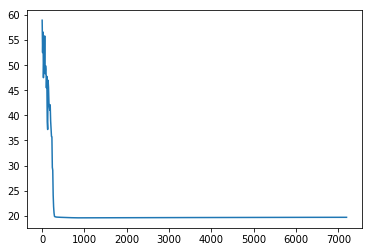

In [80]:
plt.plot([x * plot_every for x in range(len(train_plot_losses))], train_plot_losses)
plt.show()

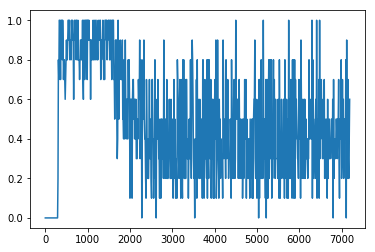

In [81]:
plt.plot([x * plot_every for x in range(len(validation_plot_losses))], validation_plot_losses)
plt.show()

In [79]:
# print(controller.first_arg)
# print(controller.second_arg)
# print(controller.output)
# print(controller.instruction)
# print(controller.registers)

cutoff = 0.7

def getBest(vec):
    maxVal, index = torch.max(vec, 0)
    if maxVal.data[0] > cutoff:
        return index.data[0]

def bestRegister(vec):
    index = getBest(vec)
    if index is not None:
        return "R" + str(1 + index)
    return "??"
    
def bestInstruction(vec):
    ops = [ 
        "STOP",
        "ZERO",
        "INC",
        "ADD",
        "SUB",
        "DEC",
        "MIN",
        "MAX",
        "READ",
        "WRITE",
        "JEZ"
    ]
    index = getBest(vec)
    if index is not None:
        return ops[index]
    return "??"
    
# registers = controller.registers
orig_register = [6,2,0,1,0,0]
orig_output = [4,3,5,3,4,5,5,5]
orig_instruction = [8,8,10,5,2,10,9,0]
orig_first = [4,3,3,3,4,2,2,5]
orig_second = [5,5,0,5,5,1,4,5]
# print(controller.output)
# print(controller.first_arg)
# output = controller.output
# first = controller.first_arg
# second = controller.second_arg
instruction = controller.instruction
_, R, M = controller.registers.size()
    
def printProgram():   
    # Print registers
    for i in range(R):
        print("R" + str(i + 1) + " = " + str(getBest(controller.registers[0, i,:])))

    print()

    # Print the actual program
    for i in range (M):
        print(bestRegister(controller.output[0, :, i]) + " = " + 
              bestInstruction(controller.instruction[0, :, i]) + "(" +
              bestRegister(controller.first_arg[0, :, i]) + ", " +
              bestRegister(controller.second_arg[0, :, i]) + ")")




    
def compareOutput():
    # compare our output to theirs
    # we get one point for every matching number
    match_count = 0
    softmax = nn.Softmax(1)
    for i in range(R):
        if getBest(controller.registers[0, i,:]) == orig_register[i]:
            match_count += 1
    for i in range (M):
        if getBest(softmax(controller.output)[0, :, i]) == orig_output[i]:
            match_count += 1
        if getBest(softmax(controller.instruction)[0, :, i]) == orig_instruction[i]:
            match_count += 1
        if getBest(softmax(controller.first_arg)[0, :, i]) == orig_first[i]:
            match_count += 1
        if getBest(softmax(controller.second_arg)[0, :, i]) == orig_second[i]:
            match_count += 1

    percent_orig = match_count / (len(orig_register) + len(orig_output) + 
                                           len(orig_instruction) + len(orig_first) + len(orig_second))
    return percent_orig
    print("PERCENT MATCH", percent_orig)
    
printProgram()
compareOutput()

# Original Add Program   
# R1 = 6
# R2 = 2
# R3 = 0
# R4 = 1
# R5 = 0
# R6 = 0


# R5 = READ(R5, R6)
# R4 = READ(R4, R6)
# R6 = JEZ(R4, R1)
# R4 = DEC(R4, R6)
# R5 = INC(R5, R6)
# R6 = JEZ(R3, R2)
# R6 = WRITE(R3, R5)
# R6 = STOP(R6, R6)


R1 = 6
R2 = 2
R3 = 0
R4 = 1
R5 = None
R6 = 0

R5 = READ(R5, R6)
R4 = READ(R4, R6)
R6 = JEZ(R4, R1)
R4 = DEC(R4, R6)
R5 = INC(R5, R6)
R6 = JEZ(R3, R2)
R6 = WRITE(R3, R5)
R6 = STOP(R6, R6)


0.9736842105263158

In [53]:
# Test a bunch of times
num_trials = 20

num_original_convergences = 0
num_0_losses = 0
num_better_convergences = 0
for i in range(num_trials):
    print("Trial ", i)
    best_model, train_plot_losses, validation_plot_losses = training.train_model_anc(
        controller, 
        data_loader,  
        optimizer, 
        num_epochs = 1, 
        print_every = 10000, 
        plot_every = plot_every, 
        deep_copy_desired = False, 
        validation_criterion = anc_validation_criterion, 
        forward_train = True, 
        batch_size = 5) # In the paper, they used batch sizes of 1 or 5
    percent_orig = compareOutput()
    if percent_orig > .99:
        num_original_convergences += 1
    end_losses = validation_plot_losses[-2:]
    if sum(end_losses) < .01:
        num_0_losses += 1
    if percent_orig < .99 and sum(end_losses) < .01:
        num_
print("LOSS CONVERGENCES", num_0_losses * 1.0 / num_trials)
print("ORIG CONVERGENCES", num_original_convergences * 1.0 / num_trials)
print("BETTER CONVERGENCES", num_better_convergences * 1.0 / num_trials)

    

Trial  0
Epoch 0/0
----------
LR is set to 0.001


KeyboardInterrupt: 

In [ ]:
softmax = nn.Softmax(1)
print(softmax(controller.instruction))
print(controller.memory)